# Temporal CDOM and SST Analysis with Bathymetry Contours - August 2012

This notebook combines the temporal analysis from diff_cdomsstv4 with bathymetry contour overlays to provide oceanographic context for the difference maps.

**Time Periods:**
- Period 1: August 24-28, 2012  
- Period 2: August 29 - September 2, 2012

**Data Sources:**
- L2 RRS data: `E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02`
- MUR L4 SST data: `E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02`
- Bathymetry data: `E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc`

**Analysis Features:**
1. Process CDOM and SST data for each time period
2. Create combined products for each period  
3. Generate difference maps (Period 2 - Period 1)
4. **Overlay bathymetry contours for oceanographic context**

### Library Imports and Setup

In [14]:
# Import essential libraries
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d
from scipy.interpolate import griddata
import xarray as xr
import matplotlib.colors
import cmocean
from datetime import datetime

import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.abspath(".."))

# Import custom pipeline components
import importlib
from pipelines import l2_pipeline, l3_pipeline
importlib.reload(l2_pipeline)
importlib.reload(l3_pipeline)
from pipelines.l2_pipeline import L2DatasetLoader, GPUDataExtractor, SelectiveInterpolator
from pipelines.l3_pipeline import L3DatasetLoader

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

print("Libraries imported successfully")

Libraries imported successfully


### Configuration Parameters

In [15]:
# --- Shared Geographical and Binning Parameters ---
lon_min, lon_max = -95.0, -88.0
lat_min, lat_max = 27.5, 30.5
lat_bins = 200
lon_bins = 300

# --- CDOM Calculation Constants ---
B0 = 0.2487
B1 = 14.028
B2 = 4.085

# --- Data Directories ---
data_dir_l2_rrs = r"E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02"
data_dir_mur_l4 = r"E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02"
bathymetry_file = r"E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc"

# --- Processing Parameters ---
rrs_vars_list = ['Rrs_412', 'Rrs_555']
rrs_data_group = 'geophysical_data'
mur_l4_variable = 'analysed_sst'
interpolation_threshold = 128

# --- Bathymetry Contour Configuration ---
contour_levels = [-200, -100, -75, -50, -40, -30, -20, -15, -10, -5]
major_contour_levels = [-200, -100, -50, -20, -10]
contour_colors = 'black'
contour_linewidths = 1.0
major_contour_linewidths = 1.5
contour_alpha = 0.9

print(f"Region: Lon ({lon_min}, {lon_max}), Lat ({lat_min}, {lat_max})")
print(f"Grid: {lat_bins} lat bins, {lon_bins} lon bins")
print(f"L2 RRS Data Directory: {data_dir_l2_rrs}")
print(f"MUR L4 Data Directory: {data_dir_mur_l4}")
print(f"Bathymetry file: {bathymetry_file}")
print(f"Contour levels: {contour_levels}")

Region: Lon (-95.0, -88.0), Lat (27.5, 30.5)
Grid: 200 lat bins, 300 lon bins
L2 RRS Data Directory: E:\satdata\Texas Louisiana Shelf_2012-08-24_2012-09-02
MUR L4 Data Directory: E:\satdata\MUR-JPL-L4-GLOB-v4.1_Texas Louisiana Shelf_2012-08-24_2012-09-02
Bathymetry file: E:\geodata\gebco_2024_sub_ice_topo\GEBCO_2024_sub_ice_topo.nc
Contour levels: [-200, -100, -75, -50, -40, -30, -20, -15, -10, -5]


### Load Bathymetry Data

In [16]:
# Load GEBCO bathymetry data
print("Loading GEBCO bathymetry data...")
try:
    # Open the NetCDF dataset
    bathy_ds = xr.open_dataset(bathymetry_file)
    print(f"Dataset loaded successfully")
    
    # Subset bathymetry to study region
    print("Subsetting data to study region...")
    bathy_subset = bathy_ds.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Extract bathymetry data and coordinates
    bathy_data = bathy_subset['elevation']  # GEBCO uses 'elevation' as variable name
    bathy_lon = bathy_subset['lon']
    bathy_lat = bathy_subset['lat']
    
    # Display data information
    print(f"\nBathymetry data successfully loaded:")
    print(f"  Data shape: {bathy_data.shape}")
    print(f"  Longitude range: {float(bathy_lon.min()):.3f} to {float(bathy_lon.max()):.3f}°")
    print(f"  Latitude range: {float(bathy_lat.min()):.3f} to {float(bathy_lat.max()):.3f}°")
    print(f"  Elevation range: {float(bathy_data.min()):.1f} to {float(bathy_data.max()):.1f} meters")
    
    bathy_available = True
    
except Exception as e:
    print(f"Error loading bathymetry data: {e}")
    print("Proceeding without bathymetry overlay.")
    bathy_available = False

Loading GEBCO bathymetry data...
Dataset loaded successfully
Subsetting data to study region...

Bathymetry data successfully loaded:
  Data shape: (720, 1680)
  Longitude range: -94.998 to -88.002°
  Latitude range: 27.502 to 30.498°
  Elevation range: -2647.0 to 77.0 meters


### Utility Functions

In [17]:
def filter_files_by_date_range(file_list, start_date, end_date):
    """Filter files based on date range in filename"""
    filtered_files = []
    for file_path in file_list:
        filename = os.path.basename(file_path)
        # Extract date from filename (assuming format with date like 20120824)
        try:
            if 'A2012' in filename:  # MODIS Aqua format
                date_str = filename.split('A2012')[1][:3]  # Day of year
                file_date = datetime.strptime(f'2012{date_str}', '%Y%j')
            else:
                # Try to find date pattern YYYYMMDD
                import re
                date_match = re.search(r'(2012\d{4})', filename)
                if date_match:
                    file_date = datetime.strptime(date_match.group(1), '%Y%m%d')
                else:
                    continue
            
            if start_date <= file_date <= end_date:
                filtered_files.append(file_path)
        except:
            continue
    return filtered_files

def index_sst_maps(data_array, sst_min, sst_max):
    """Normalize SST data to 0-1 range"""
    original_nans = np.isnan(data_array)
    indexed = (sst_max - data_array) / (sst_max - sst_min)
    indexed = np.clip(indexed, 0, 1)
    indexed[original_nans] = np.nan
    return indexed

def normalize_cdom_custom(data_array, cdom_min=0.01, cdom_max=0.16):
    """Normalize CDOM data to 0-1 range"""
    clamped_data = np.clip(data_array, cdom_min, cdom_max)
    normalized_array = (clamped_data - cdom_min) / (cdom_max - cdom_min)
    normalized_array[np.isnan(data_array)] = np.nan
    return normalized_array

def get_bin_edges_from_centers(centers):
    """Convert bin centers to bin edges"""
    diffs = np.diff(centers)
    edges = np.concatenate(([centers[0] - diffs[0]/2],
                           centers[:-1] + diffs/2,
                           [centers[-1] + diffs[-1]/2]))
    return edges

def add_bathymetry_contours(ax, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors='black', linewidths=1.0, alpha=0.9, add_labels=True):
    """Add bathymetry contours to existing plot"""
    if not bathy_available:
        return None
    
    # Add contour lines
    contours = ax.contour(bathy_lon, bathy_lat, bathy_data, 
                         levels=contour_levels, colors=colors, 
                         linewidths=linewidths, alpha=alpha,
                         transform=ccrs.PlateCarree())
    
    # Add contour labels if requested
    if add_labels:
        labels = ax.clabel(contours, inline=True, fontsize=8, fmt='%d', 
                          inline_spacing=8, manual=False)
        
        # Style the contour labels
        for label in labels:
            label.set_fontweight('bold')
            label.set_bbox(dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.7))
            label.set_color('black')
    
    return contours

print("Utility functions loaded successfully.")

Utility functions loaded successfully.


In [18]:
def process_period_data(l2_files, mur_files, period_name):
    """Process CDOM and SST data for a specific time period"""
    print(f"\n=== Processing {period_name} ===")
    
    # Process CDOM data
    print(f"Processing {len(l2_files)} L2 RRS files for CDOM...")
    
    # Load L2 datasets
    loader_rrs = L2DatasetLoader(variables=rrs_vars_list, group=rrs_data_group)
    datasets_rrs = loader_rrs.load_multiple(l2_files)
    print(f"Loaded {len(datasets_rrs)} L2 RRS datasets")
    
    # Extract CDOM data
    if datasets_rrs:
        extractor_rrs = GPUDataExtractor(variables=rrs_vars_list)
        lon_rrs_flat, lat_rrs_flat, rrs_vars_data_flat = extractor_rrs.extract(datasets_rrs)
        print(f"Extracted {len(lon_rrs_flat)} CDOM data points")
        
        # Calculate CDOM
        if lon_rrs_flat.size > 0:
            Rss412 = rrs_vars_data_flat.get('Rrs_412', np.array([]))
            Rss555 = rrs_vars_data_flat.get('Rrs_555', np.array([]))
            
            term_ratio = Rss412 / Rss555
            term_numerator = term_ratio - B0
            term_division = term_numerator / B2
            valid_log_mask = term_division > 0
            
            cdom_values = np.full_like(term_division, np.nan)
            if np.any(valid_log_mask):
                cdom_values[valid_log_mask] = (np.log(term_division[valid_log_mask])) / (-B1)
            
            # Filter valid data
            valid_mask = ~np.isnan(lon_rrs_flat) & ~np.isnan(lat_rrs_flat) & ~np.isnan(cdom_values)
            final_lon_cdom = lon_rrs_flat[valid_mask]
            final_lat_cdom = lat_rrs_flat[valid_mask]
            final_cdom_raw = cdom_values[valid_mask]
            
            # Clip and bin CDOM
            clip_mask = ((final_lon_cdom >= lon_min) & (final_lon_cdom <= lon_max) &
                        (final_lat_cdom >= lat_min) & (final_lat_cdom <= lat_max))
            clipped_lon_cdom = final_lon_cdom[clip_mask]
            clipped_lat_cdom = final_lat_cdom[clip_mask]
            clipped_cdom_raw = final_cdom_raw[clip_mask]
            
            if clipped_lon_cdom.size > 0:
                binned_cdom_raw, lat_edges, lon_edges, _ = binned_statistic_2d(
                    clipped_lat_cdom, clipped_lon_cdom, clipped_cdom_raw,
                    statistic='mean', bins=[lat_bins, lon_bins], 
                    range=[[lat_min, lat_max], [lon_min, lon_max]]
                )
                cdom_data = SelectiveInterpolator.interpolate(
                    binned_cdom_raw, lat_edges, lon_edges, threshold=interpolation_threshold
                )
            else:
                cdom_data = np.full((lat_bins, lon_bins), np.nan)
                lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
                lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
        else:
            cdom_data = np.full((lat_bins, lon_bins), np.nan)
            lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
            lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    else:
        cdom_data = np.full((lat_bins, lon_bins), np.nan)
        lat_edges = np.linspace(lat_min, lat_max, lat_bins + 1)
        lon_edges = np.linspace(lon_min, lon_max, lon_bins + 1)
    
    # Process SST data
    print(f"Processing {len(mur_files)} MUR L4 files for SST...")
    l3_loader = L3DatasetLoader(variables=[mur_l4_variable], bbox=(lon_min, lon_max, lat_min, lat_max))
    mur_datasets = l3_loader.load_multiple(mur_files)
    
    if mur_datasets:
        # Average multiple days if present
        all_sst = []
        for ds in mur_datasets:
            sst_data = ds[mur_l4_variable].values
            if sst_data.ndim == 3:  # Remove time dimension if present
                sst_data = np.squeeze(sst_data)
            all_sst.append(sst_data)
        
        if all_sst:
            sst_data = np.nanmean(all_sst, axis=0)
            sst_celsius = sst_data - 273.15  # Convert to Celsius
            mur_lat = mur_datasets[0]['lat'].values
            mur_lon = mur_datasets[0]['lon'].values
        else:
            sst_celsius = np.full((lat_bins, lon_bins), np.nan)
            mur_lat = np.linspace(lat_min, lat_max, lat_bins)
            mur_lon = np.linspace(lon_min, lon_max, lon_bins)
    else:
        sst_celsius = np.full((lat_bins, lon_bins), np.nan)
        mur_lat = np.linspace(lat_min, lat_max, lat_bins)
        mur_lon = np.linspace(lon_min, lon_max, lon_bins)
    
    # Create combined product
    # Interpolate CDOM to SST grid if needed
    if cdom_data.shape != sst_celsius.shape:
        cdom_lat_centers = (lat_edges[:-1] + lat_edges[1:]) / 2
        cdom_lon_centers = (lon_edges[:-1] + lon_edges[1:]) / 2
        cdom_lat_mesh, cdom_lon_mesh = np.meshgrid(cdom_lat_centers, cdom_lon_centers, indexing='ij')
        mur_lat_mesh, mur_lon_mesh = np.meshgrid(mur_lat, mur_lon, indexing='ij')
        
        cdom_interp = griddata(
            (cdom_lat_mesh.flatten(), cdom_lon_mesh.flatten()),
            cdom_data.flatten(),
            (mur_lat_mesh, mur_lon_mesh),
            method='linear',
            fill_value=np.nan
        )
    else:
        cdom_interp = cdom_data
    
    # Normalize and combine
    sst_indexed = index_sst_maps(sst_celsius, sst_min=25, sst_max=30)
    cdom_normalized = normalize_cdom_custom(cdom_interp, cdom_min=0.015, cdom_max=0.06)
    combined_product = cdom_normalized * sst_indexed
    
    print(f"CDOM range: {np.nanmin(cdom_interp):.4f} to {np.nanmax(cdom_interp):.4f}")
    print(f"SST range: {np.nanmin(sst_celsius):.2f} to {np.nanmax(sst_celsius):.2f} °C")
    print(f"Combined product range: {np.nanmin(combined_product):.4f} to {np.nanmax(combined_product):.4f}")
    
    return combined_product, mur_lat, mur_lon, cdom_interp, sst_celsius

print("Data processing function defined.")

Data processing function defined.


### Data File Discovery and Filtering

In [19]:
# Find all data files
l2_files_all = glob.glob(os.path.join(data_dir_l2_rrs, '**', '*.nc'), recursive=True)
mur_files_all = glob.glob(os.path.join(data_dir_mur_l4, '*.nc'))

print(f"Found {len(l2_files_all)} L2 RRS files total")
print(f"Found {len(mur_files_all)} MUR L4 files total")

# Define time periods
period1_start = datetime(2012, 8, 24)
period1_end = datetime(2012, 8, 28)
period2_start = datetime(2012, 8, 29)
period2_end = datetime(2012, 9, 2)

# Filter files by time periods
l2_files_period1 = filter_files_by_date_range(l2_files_all, period1_start, period1_end)
l2_files_period2 = filter_files_by_date_range(l2_files_all, period2_start, period2_end)
mur_files_period1 = filter_files_by_date_range(mur_files_all, period1_start, period1_end)
mur_files_period2 = filter_files_by_date_range(mur_files_all, period2_start, period2_end)

print(f"\nPeriod 1 (Aug 24-28, 2012):")
print(f"  L2 RRS files: {len(l2_files_period1)}")
print(f"  MUR L4 files: {len(mur_files_period1)}")

print(f"\nPeriod 2 (Aug 29 - Sep 2, 2012):")
print(f"  L2 RRS files: {len(l2_files_period2)}")
print(f"  MUR L4 files: {len(mur_files_period2)}")

# Show some example filenames
if l2_files_period1:
    print(f"\nExample L2 Period 1 file: {os.path.basename(l2_files_period1[0])}")
if mur_files_period1:
    print(f"Example MUR Period 1 file: {os.path.basename(mur_files_period1[0])}")
if l2_files_period2:
    print(f"Example L2 Period 2 file: {os.path.basename(l2_files_period2[0])}")
if mur_files_period2:
    print(f"Example MUR Period 2 file: {os.path.basename(mur_files_period2[0])}")

Found 15 L2 RRS files total
Found 11 MUR L4 files total

Period 1 (Aug 24-28, 2012):
  L2 RRS files: 8
  MUR L4 files: 5

Period 2 (Aug 29 - Sep 2, 2012):
  L2 RRS files: 7
  MUR L4 files: 5

Example L2 Period 1 file: AQUA_MODIS.20120824T182501.L2.OC.nc
Example MUR Period 1 file: 20120824090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc
Example L2 Period 2 file: AQUA_MODIS.20120829T184501.L2.OC.nc
Example MUR Period 2 file: 20120829090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc


### Process Period 1 Data (August 24-28, 2012)

In [20]:
combined_period1, lat_grid, lon_grid, cdom_period1, sst_period1 = process_period_data(
    l2_files_period1, mur_files_period1, "Period 1 (Aug 24-28, 2012)"
)


=== Processing Period 1 (Aug 24-28, 2012) ===
Processing 8 L2 RRS files for CDOM...
Loaded 8 L2 RRS datasets
Loaded 8 L2 RRS datasets
Extracted 2052727 CDOM data points
Extracted 2052727 CDOM data points
Processing 5 MUR L4 files for SST...
Processing 5 MUR L4 files for SST...
CDOM range: -0.1691 to 0.5770
SST range: 28.42 to 30.49 °C
Combined product range: 0.0000 to 0.2833
CDOM range: -0.1691 to 0.5770
SST range: 28.42 to 30.49 °C
Combined product range: 0.0000 to 0.2833


### Process Period 2 Data (August 29 - September 2, 2012)

In [21]:
combined_period2, _, _, cdom_period2, sst_period2 = process_period_data(
    l2_files_period2, mur_files_period2, "Period 2 (Aug 29 - Sep 2, 2012)"
)


=== Processing Period 2 (Aug 29 - Sep 2, 2012) ===
Processing 7 L2 RRS files for CDOM...
Loaded 7 L2 RRS datasets
Loaded 7 L2 RRS datasets
Extracted 2989407 CDOM data points
Extracted 2989407 CDOM data points
Processing 5 MUR L4 files for SST...
Processing 5 MUR L4 files for SST...
CDOM range: -0.1299 to 0.8379
SST range: 27.54 to 30.22 °C
Combined product range: 0.0000 to 0.4446
CDOM range: -0.1299 to 0.8379
SST range: 27.54 to 30.22 °C
Combined product range: 0.0000 to 0.4446


### Calculate Temporal Differences

In [22]:
# Calculate differences (Period 2 - Period 1)
combined_diff = combined_period2 - combined_period1
cdom_diff = cdom_period2 - cdom_period1
sst_diff = sst_period2 - sst_period1

# Calculate statistics
print(f"Combined Product Difference Statistics:")
print(f"  Range: {np.nanmin(combined_diff):.4f} to {np.nanmax(combined_diff):.4f}")
print(f"  Mean: {np.nanmean(combined_diff):.4f}")
print(f"  Std: {np.nanstd(combined_diff):.4f}")

print(f"\nCDOM Difference Statistics:")
print(f"  Range: {np.nanmin(cdom_diff):.6f} to {np.nanmax(cdom_diff):.6f}")
print(f"  Mean: {np.nanmean(cdom_diff):.6f}")

print(f"\nSST Difference Statistics:")
print(f"  Range: {np.nanmin(sst_diff):.3f} to {np.nanmax(sst_diff):.3f} °C")
print(f"  Mean: {np.nanmean(sst_diff):.3f} °C")

# Set up plot extent
if lat_grid.ndim == 1 and lon_grid.ndim == 1:
    lat_edges = get_bin_edges_from_centers(lat_grid)
    lon_edges = get_bin_edges_from_centers(lon_grid)
    plot_lat_edges = lat_edges
    plot_lon_edges = lon_edges
    extent = [lon_grid[0], lon_grid[-1], lat_grid[0], lat_grid[-1]]
else:
    plot_lat_edges = lat_grid
    plot_lon_edges = lon_grid
    extent = [lon_grid[0,0], lon_grid[0,-1], lat_grid[0,0], lat_grid[-1,0]]

print(f"Plot extent: {extent}")
print(f"Grid shapes - lat: {lat_grid.shape}, lon: {lon_grid.shape}")
print(f"Data shapes - combined_period1: {combined_period1.shape}, combined_period2: {combined_period2.shape}")

Combined Product Difference Statistics:
  Range: -0.1323 to 0.4294
  Mean: 0.0648
  Std: 0.0802

CDOM Difference Statistics:
  Range: -0.350470 to 0.527964
  Mean: 0.017364

SST Difference Statistics:
  Range: -2.216 to 0.841 °C
  Mean: -0.654 °C
Plot extent: [np.float32(-95.0), np.float32(-88.0), np.float32(27.5), np.float32(30.5)]
Grid shapes - lat: (301,), lon: (701,)
Data shapes - combined_period1: (301, 701), combined_period2: (301, 701)


### Visualization: Combined Products with Bathymetry Contours

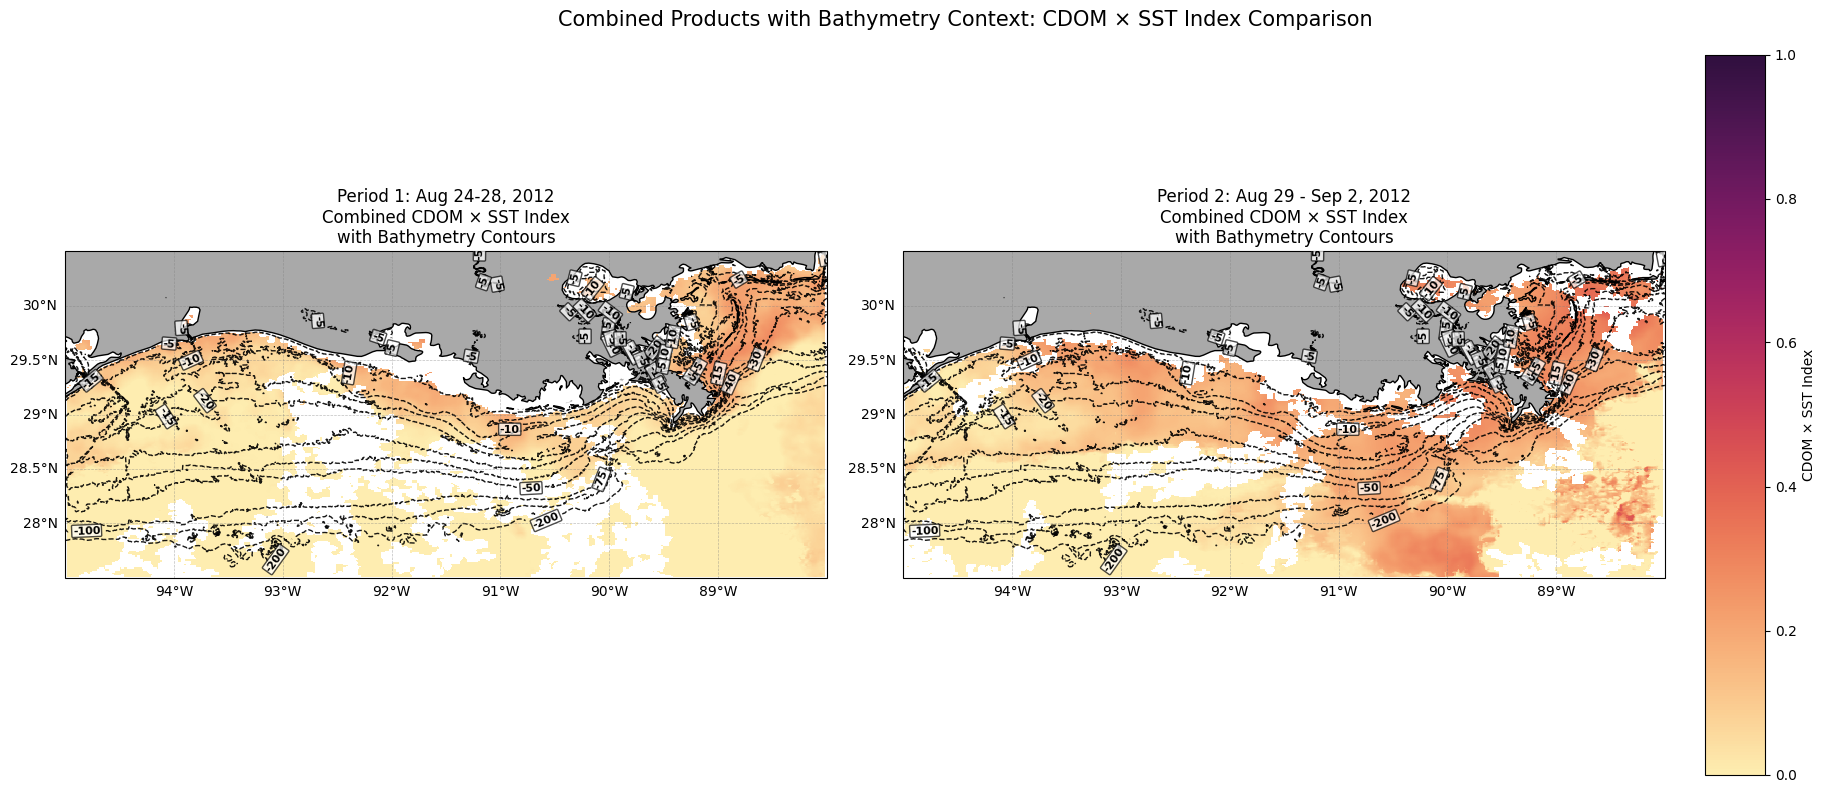

In [23]:
# Plot combined products for both periods side by side with bathymetry contours
fig, axes = plt.subplots(1, 2, figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Common settings
vmin, vmax = 0, 1
cmap = cmocean.cm.matter

# Period 1 plot
ax1 = axes[0]
ax1.set_extent(extent, crs=ccrs.PlateCarree())
combined_period1_squeezed = np.squeeze(combined_period1)
p1 = ax1.pcolormesh(plot_lon_edges, plot_lat_edges, combined_period1_squeezed,
                    cmap=cmap, shading='auto', vmin=vmin, vmax=vmax, 
                    transform=ccrs.PlateCarree())

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax1, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors=contour_colors, linewidths=contour_linewidths, 
                           alpha=contour_alpha, add_labels=True)

ax1.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_title('Period 1: Aug 24-28, 2012\nCombined CDOM × SST Index\nwith Bathymetry Contours', fontsize=12)

# Period 2 plot
ax2 = axes[1]
ax2.set_extent(extent, crs=ccrs.PlateCarree())
combined_period2_squeezed = np.squeeze(combined_period2)
p2 = ax2.pcolormesh(plot_lon_edges, plot_lat_edges, combined_period2_squeezed,
                    cmap=cmap, shading='auto', vmin=vmin, vmax=vmax, 
                    transform=ccrs.PlateCarree())

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax2, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors=contour_colors, linewidths=contour_linewidths, 
                           alpha=contour_alpha, add_labels=True)

ax2.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_title('Period 2: Aug 29 - Sep 2, 2012\nCombined CDOM × SST Index\nwith Bathymetry Contours', fontsize=12)

# Adjust subplot spacing to make room for colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1, wspace=0.1)

# Add colorbar with proper positioning
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(p2, cax=cbar_ax, label='CDOM × SST Index')

plt.suptitle('Combined Products with Bathymetry Context: CDOM × SST Index Comparison', fontsize=15, y=0.95)
plt.show()

### Visualization: Temporal Difference Map with Bathymetry Contours

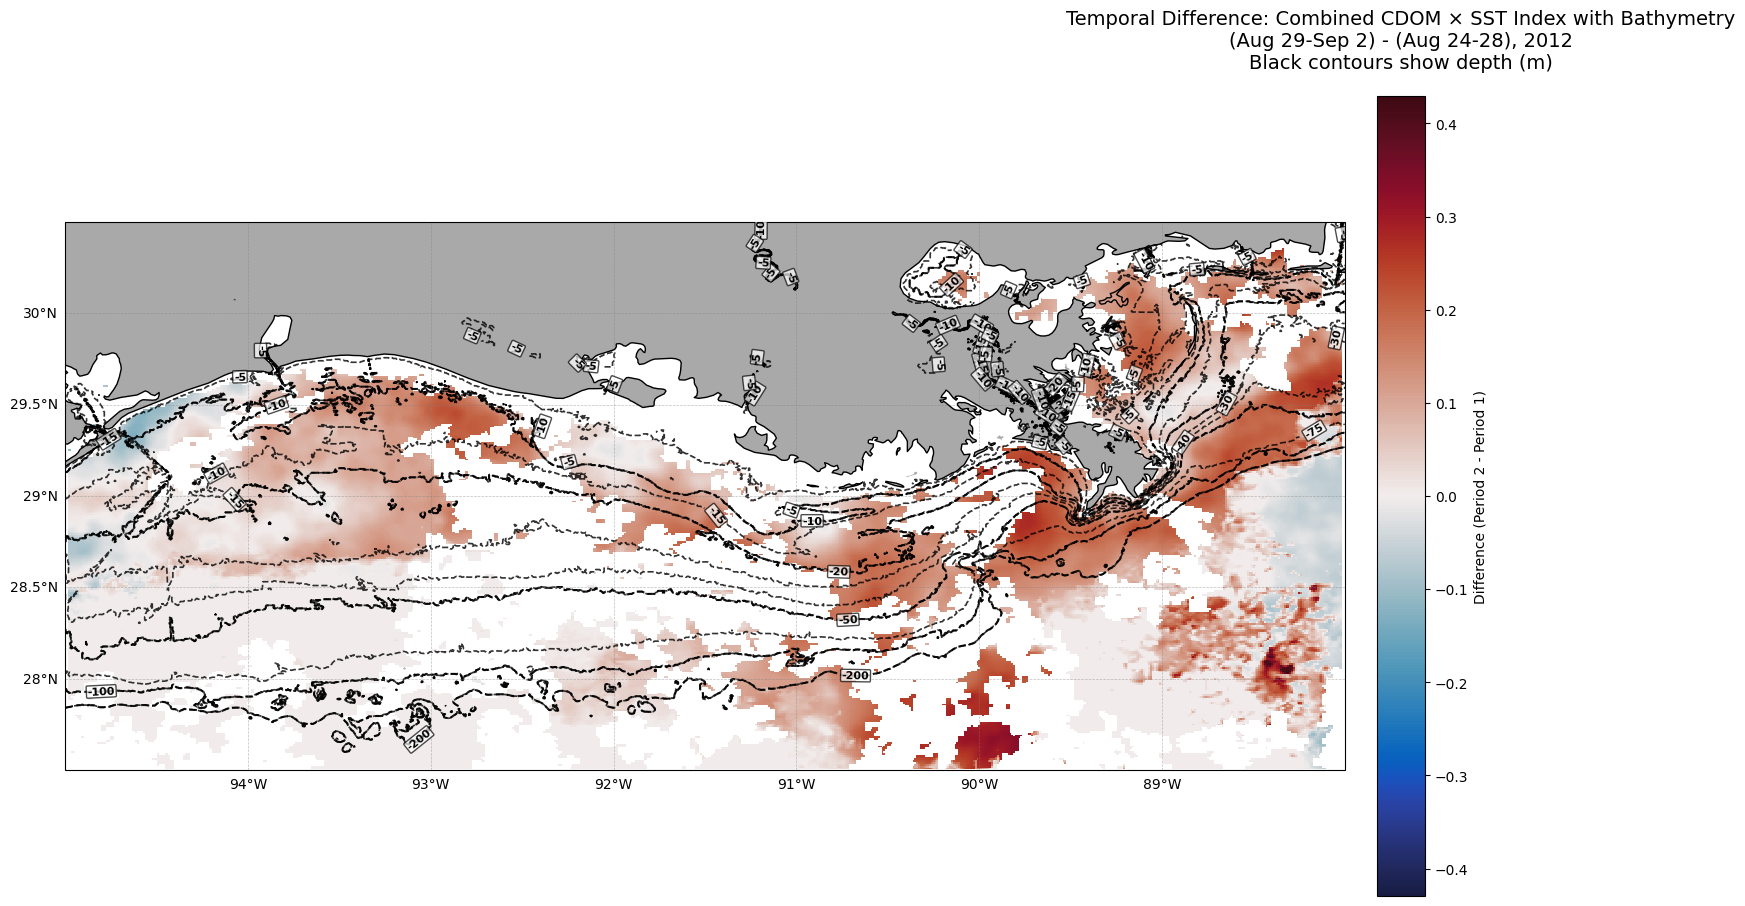


Difference Map Statistics:
  Valid data points: 86604
  Range: -0.1323 to 0.4294
  Mean: 0.0648
  Standard deviation: 0.0802
  Positive changes: 55544 (64.1%)
  Negative changes: 9444 (10.9%)


In [24]:
# Plot the temporal difference map with bathymetry contours
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Use balance colormap for differences, centered on zero
combined_diff_squeezed = np.squeeze(combined_diff)
diff_abs_max = np.nanmax(np.abs(combined_diff_squeezed))
diff_vmin, diff_vmax = -diff_abs_max, diff_abs_max

diff_plot = ax.pcolormesh(plot_lon_edges, plot_lat_edges, combined_diff_squeezed,
                         cmap=cmocean.cm.balance, shading='auto',
                         vmin=diff_vmin, vmax=diff_vmax, transform=ccrs.PlateCarree())

# Add bathymetry contours
if bathy_available:
    contours = add_bathymetry_contours(ax, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                                      colors='black', linewidths=1.2, 
                                      alpha=0.8, add_labels=True)
    
    # Add major contours with thicker lines
    major_contours = ax.contour(bathy_lon, bathy_lat, bathy_data, 
                               levels=major_contour_levels, colors='black', 
                               linewidths=major_contour_linewidths, alpha=0.9,
                               transform=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=1.0, edgecolor='black', zorder=3)
ax.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                  color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Adjust layout to make room for colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.9, bottom=0.1)

# Add colorbar with proper positioning
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.8])  # [left, bottom, width, height]
cbar = fig.colorbar(diff_plot, cax=cbar_ax, label='Difference (Period 2 - Period 1)')

plt.title('Temporal Difference: Combined CDOM × SST Index with Bathymetry\n(Aug 29-Sep 2) - (Aug 24-28), 2012\nBlack contours show depth (m)', 
          fontsize=14, pad=20)
plt.show()

# Print some summary statistics
valid_diff_data = combined_diff_squeezed[~np.isnan(combined_diff_squeezed)]
if len(valid_diff_data) > 0:
    print(f"\nDifference Map Statistics:")
    print(f"  Valid data points: {len(valid_diff_data)}")
    print(f"  Range: {np.min(valid_diff_data):.4f} to {np.max(valid_diff_data):.4f}")
    print(f"  Mean: {np.mean(valid_diff_data):.4f}")
    print(f"  Standard deviation: {np.std(valid_diff_data):.4f}")
    
    # Count positive and negative changes
    positive_changes = np.sum(valid_diff_data > 0)
    negative_changes = np.sum(valid_diff_data < 0)
    print(f"  Positive changes: {positive_changes} ({100*positive_changes/len(valid_diff_data):.1f}%)")
    print(f"  Negative changes: {negative_changes} ({100*negative_changes/len(valid_diff_data):.1f}%)")
else:
    print("No valid difference data available.")

### Individual Component Difference Maps with Bathymetry

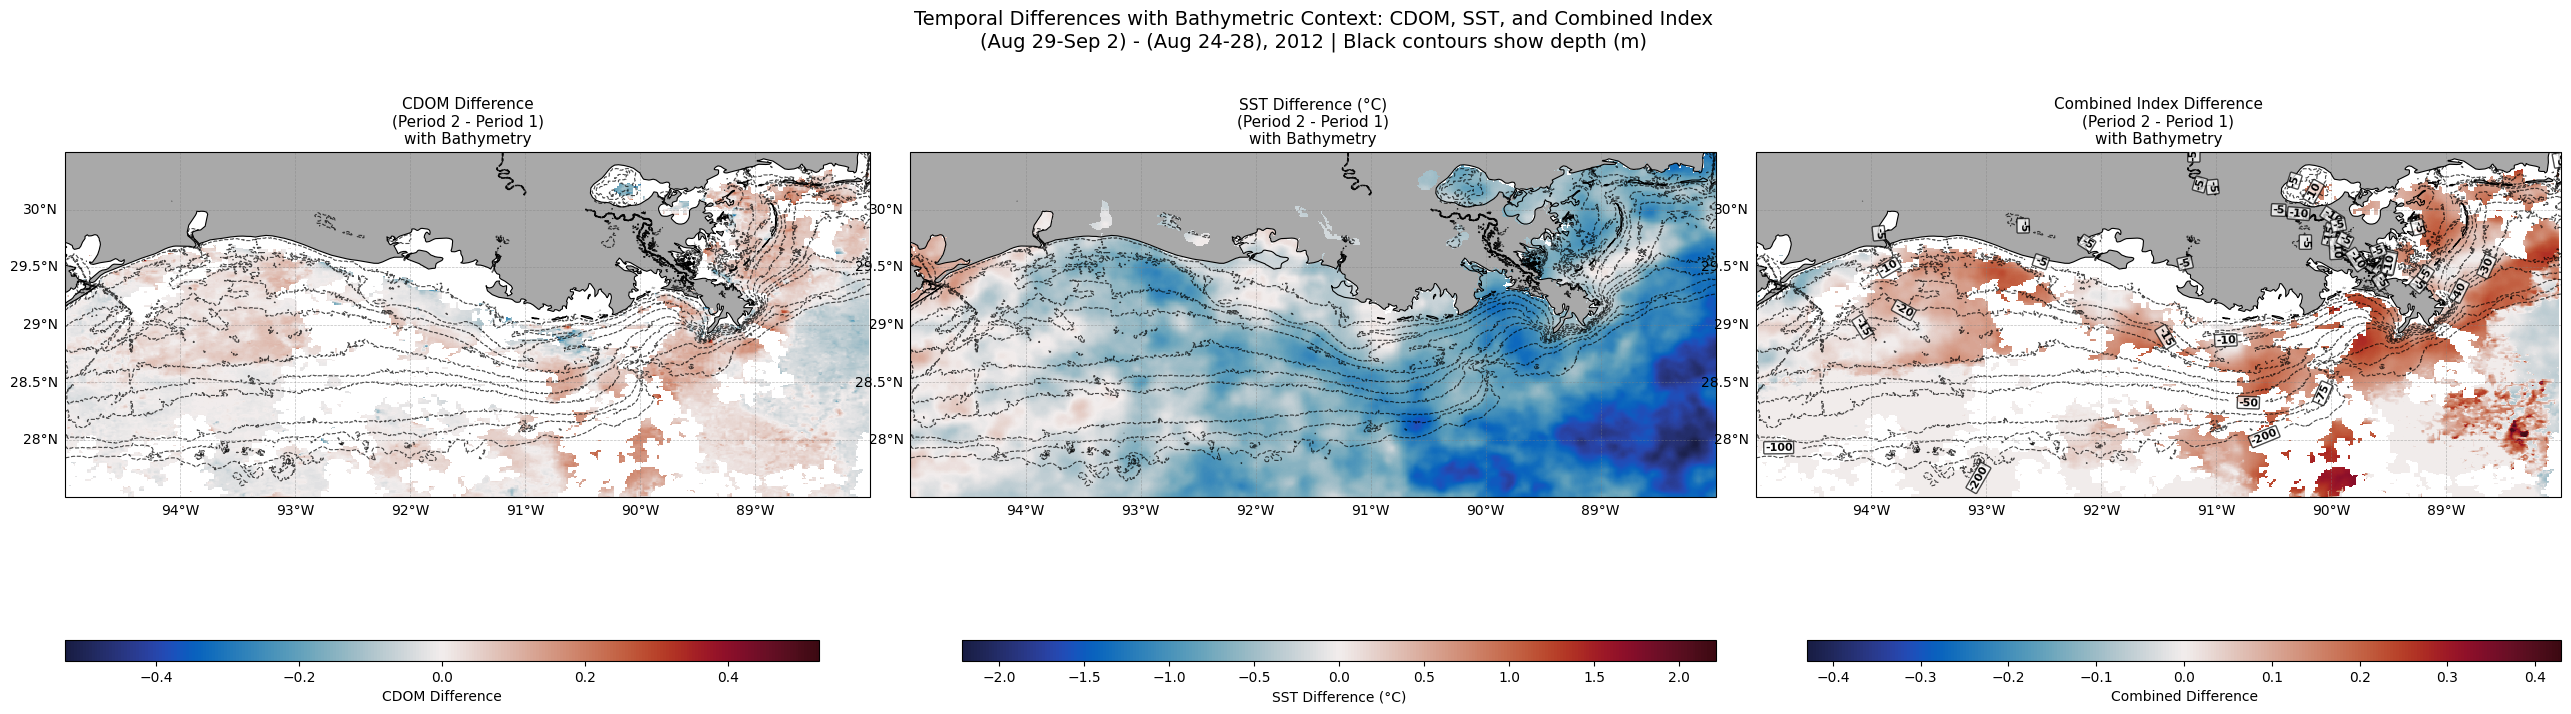

Comprehensive difference maps with bathymetry contours complete.

Bathymetry contours provide oceanographic context:
Contour levels: [-200, -100, -75, -50, -40, -30, -20, -15, -10, -5] meters
Major contours (thicker lines): [-200, -100, -50, -20, -10] meters


In [25]:
# Create individual difference maps for CDOM and SST with bathymetry contours
cdom_diff_squeezed = np.squeeze(cdom_diff)
sst_diff_squeezed = np.squeeze(sst_diff)

# Calculate difference ranges for consistent colormaps
cdom_diff_abs_max = np.nanmax(np.abs(cdom_diff_squeezed))
cdom_diff_vmin, cdom_diff_vmax = -cdom_diff_abs_max, cdom_diff_abs_max

sst_diff_abs_max = np.nanmax(np.abs(sst_diff_squeezed))
sst_diff_vmin, sst_diff_vmax = -sst_diff_abs_max, sst_diff_abs_max

# Create a comprehensive comparison of all three difference maps with bathymetry
fig, axes = plt.subplots(1, 3, figsize=(26, 7), subplot_kw={'projection': ccrs.PlateCarree()})

# CDOM Difference
ax1 = axes[0]
ax1.set_extent(extent, crs=ccrs.PlateCarree())
p1 = ax1.pcolormesh(plot_lon_edges, plot_lat_edges, cdom_diff_squeezed,
                    cmap=cmocean.cm.balance, shading='auto',
                    vmin=cdom_diff_vmin, vmax=cdom_diff_vmax, 
                    transform=ccrs.PlateCarree())

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax1, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors='black', linewidths=0.8, alpha=0.7, add_labels=False)

ax1.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax1.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

ax1.set_title('CDOM Difference\n(Period 2 - Period 1)\nwith Bathymetry', fontsize=11)

# SST Difference
ax2 = axes[1]
ax2.set_extent(extent, crs=ccrs.PlateCarree())
p2 = ax2.pcolormesh(plot_lon_edges, plot_lat_edges, sst_diff_squeezed,
                    cmap=cmocean.cm.balance, shading='auto',
                    vmin=sst_diff_vmin, vmax=sst_diff_vmax, 
                    transform=ccrs.PlateCarree())

# Add bathymetry contours
if bathy_available:
    add_bathymetry_contours(ax2, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors='black', linewidths=0.8, alpha=0.7, add_labels=False)

ax2.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax2.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax2.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

ax2.set_title('SST Difference (°C)\n(Period 2 - Period 1)\nwith Bathymetry', fontsize=11)

# Combined Product Difference
ax3 = axes[2]
ax3.set_extent(extent, crs=ccrs.PlateCarree())
p3 = ax3.pcolormesh(plot_lon_edges, plot_lat_edges, combined_diff_squeezed,
                    cmap=cmocean.cm.balance, shading='auto',
                    vmin=diff_vmin, vmax=diff_vmax, 
                    transform=ccrs.PlateCarree())

# Add bathymetry contours with labels
if bathy_available:
    add_bathymetry_contours(ax3, bathy_lon, bathy_lat, bathy_data, contour_levels, 
                           colors='black', linewidths=0.8, alpha=0.7, add_labels=True)

ax3.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=3)
ax3.add_feature(cfeature.LAND, facecolor='darkgray', zorder=0)
ax3.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='dimgray', zorder=2)

gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, 
                    color='gray', alpha=0.5, linestyle='--')
gl3.top_labels = False
gl3.right_labels = False

ax3.set_title('Combined Index Difference\n(Period 2 - Period 1)\nwith Bathymetry', fontsize=11)

# Adjust spacing for colorbars
plt.subplots_adjust(left=0.02, right=0.98, top=0.85, bottom=0.15, wspace=0.05)

# Add individual colorbars for each subplot
# CDOM colorbar
cbar_ax1 = fig.add_axes([0.02, 0.02, 0.29, 0.03])  # [left, bottom, width, height]
cbar1 = fig.colorbar(p1, cax=cbar_ax1, orientation='horizontal', label='CDOM Difference')

# SST colorbar
cbar_ax2 = fig.add_axes([0.365, 0.02, 0.29, 0.03])  # [left, bottom, width, height]
cbar2 = fig.colorbar(p2, cax=cbar_ax2, orientation='horizontal', label='SST Difference (°C)')

# Combined colorbar
cbar_ax3 = fig.add_axes([0.69, 0.02, 0.29, 0.03])  # [left, bottom, width, height]
cbar3 = fig.colorbar(p3, cax=cbar_ax3, orientation='horizontal', label='Combined Difference')

plt.suptitle('Temporal Differences with Bathymetric Context: CDOM, SST, and Combined Index\n(Aug 29-Sep 2) - (Aug 24-28), 2012 | Black contours show depth (m)', 
             fontsize=14, y=0.95)
plt.show()

print("Comprehensive difference maps with bathymetry contours complete.")
print("\nBathymetry contours provide oceanographic context:")
print(f"Contour levels: {contour_levels} meters")
print(f"Major contours (thicker lines): {major_contour_levels} meters")

### Analysis Summary with Oceanographic Context

The bathymetry contours provide important oceanographic context for interpreting the temporal changes:

**Shallow Water Areas (< 20m depth):**
- Coastal zones where river discharge and terrestrial inputs dominate
- Typically show higher CDOM concentrations
- More susceptible to wind mixing and tidal effects

**Continental Shelf (20-100m depth):**
- Transition zone between coastal and offshore waters
- Upwelling and cross-shelf transport processes
- Important region for nutrient transport

**Deep Water Areas (> 100m depth):**
- Offshore waters with lower CDOM concentrations
- Ocean circulation and mesoscale eddy influences
- More stable thermal stratification

The overlaid bathymetry helps identify:
1. **Depth-related patterns** in CDOM and SST changes
2. **Cross-shelf gradients** and transport processes
3. **Shelf-break dynamics** and upwelling signatures
4. **River plume extent** and coastal influence zones

### Optional: Depth-Stratified Analysis

In [26]:
# Analyze changes by depth zones using bathymetry data
if bathy_available:
    print("Analyzing temporal changes by depth zones...")
    
    # Define depth zones
    depth_zones = {
        'Very Shallow (0-10m)': (0, -10),
        'Shallow (10-20m)': (-10, -20),
        'Moderate (20-50m)': (-20, -50),
        'Deep Shelf (50-100m)': (-50, -100),
        'Deep Water (>100m)': (-100, -1000)
    }
    
    # Interpolate bathymetry to match data grid
    if bathy_data.shape != combined_diff_squeezed.shape:
        # Create coordinate meshes
        bathy_lat_mesh, bathy_lon_mesh = np.meshgrid(bathy_lat, bathy_lon, indexing='ij')
        data_lat_mesh, data_lon_mesh = np.meshgrid(lat_grid, lon_grid, indexing='ij')
        
        # Interpolate bathymetry to data grid
        bathy_interp = griddata(
            (bathy_lat_mesh.flatten(), bathy_lon_mesh.flatten()),
            bathy_data.values.flatten(),
            (data_lat_mesh, data_lon_mesh),
            method='linear',
            fill_value=np.nan
        )
    else:
        bathy_interp = bathy_data.values
    
    # Analyze each depth zone
    print("\nTemporal change statistics by depth zone:")
    print("="*60)
    
    for zone_name, (shallow_limit, deep_limit) in depth_zones.items():
        # Create depth mask
        depth_mask = (bathy_interp >= deep_limit) & (bathy_interp < shallow_limit)
        
        # Extract data for this depth zone
        if np.any(depth_mask):
            zone_combined_diff = combined_diff_squeezed[depth_mask]
            zone_cdom_diff = cdom_diff_squeezed[depth_mask]
            zone_sst_diff = sst_diff_squeezed[depth_mask]
            
            # Remove NaN values
            zone_combined_valid = zone_combined_diff[~np.isnan(zone_combined_diff)]
            zone_cdom_valid = zone_cdom_diff[~np.isnan(zone_cdom_diff)]
            zone_sst_valid = zone_sst_diff[~np.isnan(zone_sst_diff)]
            
            print(f"\n{zone_name}:")
            print(f"  Grid points: {np.sum(depth_mask)}")
            print(f"  Valid data points: {len(zone_combined_valid)}")
            
            if len(zone_combined_valid) > 0:
                print(f"  Combined difference: {np.mean(zone_combined_valid):.4f} ± {np.std(zone_combined_valid):.4f}")
            if len(zone_cdom_valid) > 0:
                print(f"  CDOM difference: {np.mean(zone_cdom_valid):.6f} ± {np.std(zone_cdom_valid):.6f}")
            if len(zone_sst_valid) > 0:
                print(f"  SST difference: {np.mean(zone_sst_valid):.3f} ± {np.std(zone_sst_valid):.3f} °C")
        else:
            print(f"\n{zone_name}: No data points in this depth range")
    
    print("\n" + "="*60)
    print("Depth-stratified analysis complete.")
    
else:
    print("Depth-stratified analysis not available (no bathymetry data)")

Analyzing temporal changes by depth zones...

Temporal change statistics by depth zone:

Very Shallow (0-10m):
  Grid points: 27736
  Valid data points: 9072
  Combined difference: 0.0859 ± 0.0735
  CDOM difference: 0.015029 ± 0.061823
  SST difference: -0.374 ± 0.361 °C

Shallow (10-20m):
  Grid points: 20600
  Valid data points: 15021
  Combined difference: 0.0810 ± 0.0699
  CDOM difference: 0.023462 ± 0.049989
  SST difference: -0.462 ± 0.353 °C

Moderate (20-50m):
  Grid points: 30964
  Valid data points: 18348
  Combined difference: 0.0627 ± 0.0735
  CDOM difference: 0.026359 ± 0.038604
  SST difference: -0.519 ± 0.374 °C

Deep Shelf (50-100m):
  Grid points: 20542
  Valid data points: 10928
  Combined difference: 0.0658 ± 0.0873
  CDOM difference: 0.013465 ± 0.042972
  SST difference: -0.502 ± 0.395 °C

Deep Water (>100m):
  Grid points: 36028
  Valid data points: 18569
  Combined difference: 0.0589 ± 0.0780
  CDOM difference: 0.022886 ± 0.059352
  SST difference: -0.732 ± 0.409 